In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer  # For converting text data into TF-IDF vectors
from sklearn.metrics.pairwise import cosine_similarity  # For computing cosine similarity between vectors
from scipy.spatial.distance import pdist, squareform  # For pairwise distance computations and converting to a square matrix
import pickle

# pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [72]:
anime_df = pd.read_csv('anime_meta.csv')
rating_df = pd.read_csv('ratings.csv')

Exploratory Data Analysis

In [73]:
anime_df.head()

,anime_name,anime_id,Genres,Score,Synopsis
0,Cowboy Bebop,1,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",8.78,"In the year 2071, humanity has colonized sever..."
1,Cowboy Bebop: Tengoku no Tobira,5,"Action, Drama, Mystery, Sci-Fi, Space",8.39,"other day, another bounty—such is the life of ..."
2,Trigun,6,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",8.24,"Vash the Stampede is the man with a $$60,000,0..."
3,Witch Hunter Robin,7,"Action, Mystery, Police, Supernatural, Drama, ...",7.27,ches are individuals with special powers like ...
4,Bouken Ou Beet,8,"Adventure, Fantasy, Shounen, Supernatural",6.98,It is the dark century and the people are suff...


In [74]:
rating_df.head()

,user_id,anime_id,rating,anime_name
0,0,430,9,Fullmetal Alchemist: The Conqueror of Shamballa
1,0,1004,5,Kanojo to Kanojo no Neko
2,0,3010,7,Kaiketsu Zorro
3,0,570,7,Jin-Rou
4,0,2762,9,Igano Kabamaru


In [75]:
anime_df.size

87810

In [76]:
rating_df.size

230533112

In [77]:
anime_df['anime_name'].nunique()

17558

In [78]:
rating_df['user_id'].nunique()

310059

In [79]:
# 1) Count missing/"Unknown" values in anime_df
unk_name   = (anime_df['anime_name'] == 'Unknown').sum()
unk_score  = (anime_df['Score']       == 'Unknown').sum()
unk_genres = (anime_df['Genres']      == 'Unknown').sum()

print("anime_df: Unknown anime_name:",   unk_name)
print("anime_df: Unknown Score:",        unk_score)
print("anime_df: Unknown Genres:",       unk_genres)

# 2) Count missing/"Unknown" values in rating_df
unk_uid    = (rating_df['user_id'].astype(str) == 'Unknown').sum()
unk_aid    = (rating_df['anime_id'].astype(str) == 'Unknown').sum()
unk_rating = (rating_df['rating'].astype(str)   == 'Unknown').sum()

print("rating_df: Unknown user_id:",   unk_uid)
print("rating_df: Unknown anime_id:",  unk_aid)
print("rating_df: Unknown rating:",    unk_rating)

# 3) Drop those rows from anime_df
anime_df = anime_df[
    (anime_df['anime_name'] != 'Unknown') &
    (anime_df['Score']      != 'Unknown') &
    (anime_df['Genres']     != 'Unknown')
].reset_index(drop=True)

# 4) Drop those rows from rating_df
rating_df = rating_df[
    (rating_df['user_id'].astype(str)   != 'Unknown') &
    (rating_df['anime_id'].astype(str)  != 'Unknown') &
    (rating_df['rating'].astype(str)    != 'Unknown')
].reset_index(drop=True)

# 5) Verify that nothing remains
print("\nAfter dropping:")
print("anime_df_clean: Unknown anime_name:",   (anime_df['anime_name']=="Unknown").sum())
print("anime_df_clean: Unknown Score:",        (anime_df['Score']=="Unknown").sum())
print("anime_df_clean: Unknown Genres:",       (anime_df['Genres']=="Unknown").sum())

print("rating_df_clean: Unknown user_id:",   (rating_df['user_id'].astype(str)=="Unknown").sum())
print("rating_df_clean: Unknown anime_id:",  (rating_df['anime_id'].astype(str)=="Unknown").sum())
print("rating_df_clean: Unknown rating:",    (rating_df['rating'].astype(str)=="Unknown").sum())


anime_df: Unknown anime_name: 0
anime_df: Unknown Score: 5141
anime_df: Unknown Genres: 63
rating_df: Unknown user_id: 0
rating_df: Unknown anime_id: 0
rating_df: Unknown rating: 0

After dropping:
anime_df_clean: Unknown anime_name: 0
anime_df_clean: Unknown Score: 0
anime_df_clean: Unknown Genres: 0
rating_df_clean: Unknown user_id: 0
rating_df_clean: Unknown anime_id: 0
rating_df_clean: Unknown rating: 0


In [ ]:
# 0) If Score is object, convert to numeric (coerce errors to NaN)
anime_df['Score'] = pd.to_numeric(anime_df['Score'], errors='coerce')

# 1) Compute the true average Score per anime
avg_scores = (
    anime_df
      .groupby('anime_id')['Score']         #Initially Score meant rating by each individual user for that movie, now it means the Total Avg Rating
      .mean()
      .reset_index()
)

# 2) Pull one representative row per anime_id (keep all other columns)
#    drop duplicates based on anime_id, keeping the first
anime_meta = anime_df.drop_duplicates(subset='anime_id').copy()

# 3) Drop the old per-user Score from that
anime_meta = anime_meta.drop(columns=['Score'])

# 4) Merge the average scores back on
anime_df = anime_meta.merge(avg_scores, on='anime_id', how='left')

# 5) Verify
print(anime_df.shape)          # should be (#distinct anime, #cols)
print(anime_df.dtypes)        # Score now float
print(anime_df.head())


(12406, 5)
anime_name     object
anime_id        int64
Genres         object
Synopsis       object
Score         float64
dtype: object
                        anime_name  anime_id  \
0                     Cowboy Bebop         1   
1  Cowboy Bebop: Tengoku no Tobira         5   
2                           Trigun         6   
3               Witch Hunter Robin         7   
4                   Bouken Ou Beet         8   

                                              Genres  \
0    Action, Adventure, Comedy, Drama, Sci-Fi, Space   
1              Action, Drama, Mystery, Sci-Fi, Space   
2  Action, Sci-Fi, Adventure, Comedy, Drama, Shounen   
3  Action, Mystery, Police, Supernatural, Drama, ...   
4          Adventure, Fantasy, Shounen, Supernatural   

                                            Synopsis  Score  
0  In the year 2071, humanity has colonized sever...   8.78  
1  other day, another bounty—such is the life of ...   8.39  
2  Vash the Stampede is the man with a $$60,000,0... 

In [85]:
anime_df.size

62030

Viewing Top 50 Ranked animes

In [ ]:
Top_animes = anime_df.sort_values(by="Score", ascending=False)
# pull both columns, reset the index, and shift display index to start at 1
names_and_ratings = (
    Top_animes[['anime_name','Score']]
      .reset_index(drop=True)
)
names_and_ratings.index += 1


                                             anime_name  Score
1                      Fullmetal Alchemist: Brotherhood   9.19
2                  Shingeki no Kyojin: The Final Season   9.17
3                                           Steins;Gate   9.11
4                                Hunter x Hunter (2011)   9.10
5                    Shingeki no Kyojin Season 3 Part 2   9.10
6                                              Gintama°   9.10
7                                              Gintama'   9.08
8                                  Ginga Eiyuu Densetsu   9.07
9                                   Gintama': Enchousen   9.04
10                                       Koe no Katachi   9.00
11                           3-gatsu no Lion 2nd Season   9.00
12                                             Gintama.   8.99
13                                              Gintama   8.96
14                                       Kimi no Na wa.   8.96
15    Gintama Movie 2: Kanketsu-hen - Yorozuya yo Ei...

In [94]:
names_and_ratings.head(25)

,anime_name,Score
1,Fullmetal Alchemist: Brotherhood,9.19
2,Shingeki no Kyojin: The Final Season,9.17
3,Steins;Gate,9.11
4,Hunter x Hunter (2011),9.10
5,Shingeki no Kyojin Season 3 Part 2,9.10
6,Gintama°,9.10
7,Gintama',9.08
8,Ginga Eiyuu Densetsu,9.07
9,Gintama': Enchousen,9.04
10,Koe no Katachi,9.00


In [83]:
anime_df['Score'].max()

np.float64(9.19)

All Possible Genres

In [86]:
possible_genres = anime_df['Genres'].str.split(',').explode().str.strip().unique()
possible_genres

array(['Action', 'Adventure', 'Comedy', 'Drama', 'Sci-Fi', 'Space',
       'Mystery', 'Shounen', 'Police', 'Supernatural', 'Magic', 'Fantasy',
       'Sports', 'Josei', 'Romance', 'Slice of Life', 'Cars', 'Seinen',
       'Horror', 'Psychological', 'Thriller', 'Super Power',
       'Martial Arts', 'School', 'Ecchi', 'Vampire', 'Military',
       'Historical', 'Dementia', 'Mecha', 'Demons', 'Samurai', 'Game',
       'Shoujo', 'Harem', 'Music', 'Shoujo Ai', 'Shounen Ai', 'Kids',
       'Hentai', 'Parody', 'Yuri', 'Yaoi'], dtype=object)

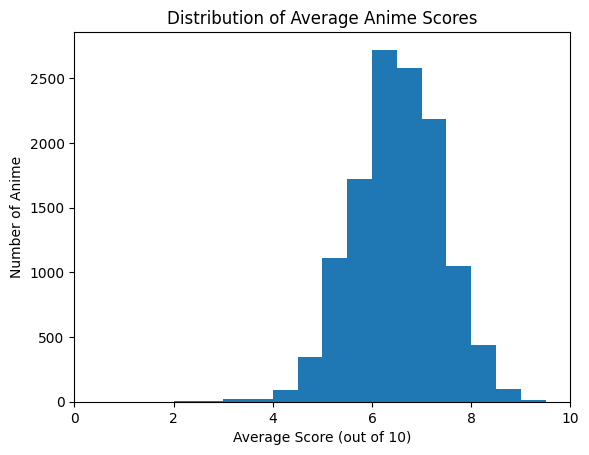

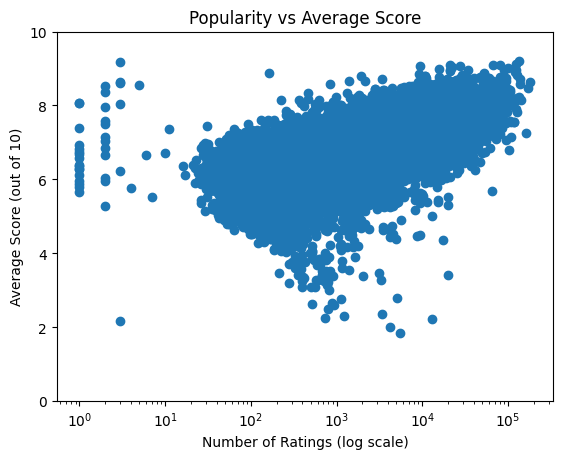

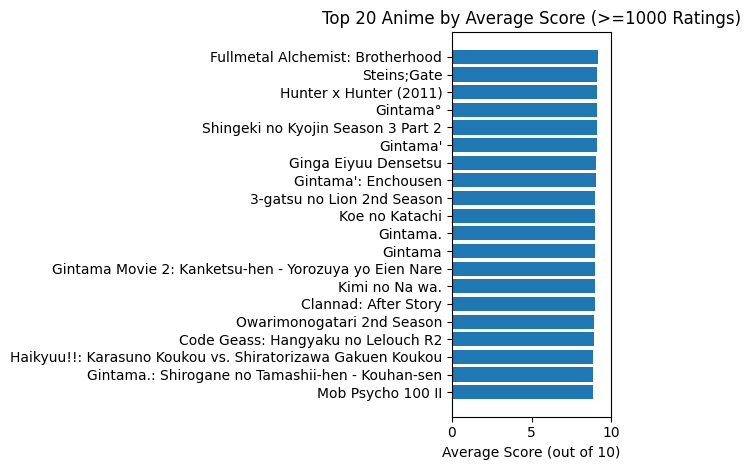

In [93]:

# 1) Build stats (avg_score + num_ratings + anime_name)
rating_counts = rating_df.groupby('anime_id')['user_id'] \
                         .count() \
                         .rename('num_ratings')
stats = pd.DataFrame({
    'avg_score': anime_df.set_index('anime_id')['Score'],
    'num_ratings': rating_counts
})
stats['anime_name'] = anime_df.set_index('anime_id')['anime_name']

# 2) Histogram of average scores (0–10)
plt.figure()
plt.hist(stats['avg_score'], bins=np.linspace(0, 10, 21), range=(0, 10))
plt.title('Distribution of Average Anime Scores')
plt.xlabel('Average Score (out of 10)')
plt.ylabel('Number of Anime')
plt.xlim(0, 10)
plt.show()

# 3) Scatter: popularity vs. average score
plt.figure()
plt.scatter(stats['num_ratings'], stats['avg_score'])
plt.xscale('log')
plt.title('Popularity vs Average Score')
plt.xlabel('Number of Ratings (log scale)')
plt.ylabel('Average Score (out of 10)')
plt.ylim(0, 10)
plt.show()

# 4) Top 20 anime by average score (min 1000 ratings)
top20 = stats[stats['num_ratings'] > 1000] \
            .sort_values('avg_score', ascending=False) \
            .head(20)
plt.figure()
plt.barh(top20['anime_name'][::-1], top20['avg_score'][::-1])
plt.title('Top 20 Anime by Average Score (>=1000 Ratings)')
plt.xlabel('Average Score (out of 10)')
plt.xlim(0, 10)
plt.tight_layout()
plt.show()


In [95]:
# Save anime_df_clean
with open('anime_df_clean.pkl', 'wb') as f:
    pickle.dump(anime_df, f)

# Save rating_df_clean
with open('rating_df_clean.pkl', 'wb') as f:
    pickle.dump(rating_df, f)


##FIX FROM HERE## Add Non Personalized. 

In [87]:
# Instantiate a TfidfVectorizer with parameters to remove stop words and filter out very common/rare terms
vectorizer = TfidfVectorizer(min_df=2, max_df=0.7, stop_words='english')

In [89]:
# Fit the vectorizer on the 'plot' column and transform the text into TF-IDF vectors
vectorized_data = vectorizer.fit_transform(df_content['synopsis'])

NameError: name 'df_content' is not defined

In [9]:
# Explore the generated features (vocabulary terms)
print(vectorizer.get_feature_names_out())
#some japanese words here

['00' '000' '001' ... 'éclair' 'état' 'être']


In [10]:
# Convert the TF-IDF sparse matrix to a DataFrame with feature names as columns
tfidf_df = pd.DataFrame(
    vectorized_data.toarray(),
    columns=vectorizer.get_feature_names_out()
)

In [11]:
tfidf_df.head()
# max columns LOOOOL

,00,000,001,0079,0083,...,zutto,zwei,éclair,état,être
0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0


In [12]:
# Assign the show titles to the DataFrame's index for easier reference
tfidf_df.index = df_content['English']
# tfidf_df.head()

In [13]:
# no need because we pickled
cosine_similarity_array = cosine_similarity(tfidf_df)


In [14]:
# store locally
with open("coSim_ESdrop.pkl", "wb") as f:
    pickle.dump(cosine_similarity_array, f)

In [ ]:
# to load
with open("coSim_ESdrop.pkl", "rb") as f:
    cosine_similarity_array = pickle.load(f)

print(cosine_similarity_array)

In [15]:
# Convert the cosine similarity array into a DataFrame with show titles as both index and columns
cosine_similarity_df = pd.DataFrame(
    cosine_similarity_array,
    index=tfidf_df.index,
    columns=tfidf_df.index
)


In [60]:
cosine_similarity_df.head()

English,Attack on Titan,Death Note,Fullmetal Alchemist Brotherhood,One Punch Man,Sword Art Online,...,Mumu Tribe,Cloud Bread,Cloud Bread 2,Tobot Movie Attack of Robot Force,Dino King
English,,,,,,,,,,,
Attack on Titan,1.000000,0.036339,0.036858,0.011122,0.016195,...,0.0,0.0,0.0,0.0,0.0
Death Note,0.036339,1.000000,0.028416,0.012076,0.031240,...,0.0,0.0,0.0,0.0,0.0
Fullmetal Alchemist Brotherhood,0.036858,0.028416,1.000000,0.012120,0.016767,...,0.0,0.0,0.0,0.0,0.0
One Punch Man,0.011122,0.012076,0.012120,1.000000,0.022714,...,0.0,0.0,0.0,0.0,0.0
Sword Art Online,0.016195,0.031240,0.016767,0.022714,1.000000,...,0.0,0.0,0.0,0.0,0.0


In [16]:
cosine_similarity_series = cosine_similarity_df.loc["One Punch Man"]
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)


In [17]:
# pd.set_option('display.max_rows', None)
# print(ordered_similarities)

# for i in range(0,20):
#     if ordered_similarities.values[i]>0.1:
#         print(ordered_similarities.index[i])
#         print(ordered_similarities.values[i])
#         print("")

ordered_similarities


English
One Punch Man                                                 1.000000
One Punch Man Season 2                                        0.298783
Ninja Slayer From Animation                                   0.152687
One Outs                                                      0.126590
Yuki Yuna is a Hero                                           0.096680
                                                                ...   
Zatch Bell!                                                   0.000000
Chidori RSC Nationals Are Right Before Us                     0.000000
Hareluya II Boy                                               0.000000
Tales of Demons and Gods Season 5                             0.000000
Heaven's Lost Property the Movie The Angeloid of Clockwork    0.000000
Name: One Punch Man, Length: 8409, dtype: float64

One Punch Man                                   1.000000
Unknown                                         0.334311
Unknown                                         0.321005
One Punch Man Season 2                          0.271798
Unknown                                         0.247187

<center><h2>Jaccard</h2></center>

In [5]:
df_jaccard = anime_df[["English", "Genres"]]
df_jaccard = df_jaccard[(df_jaccard["Genres"] != 'Unknown') & (df_jaccard['English'] != 'Unknown')]


In [6]:
df_jaccard.head()

,English,Genres
0,Attack on Titan,"Action, Drama"
1,Death Note,"Supernatural, Suspense"
2,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy"
3,One Punch Man,"Action, Comedy"
4,Sword Art Online,"Action, Adventure, Fantasy, Romance"


In [7]:
# Create a cross-tabulated DataFrame (contingency table) with show titles as rows and genres as columns
animes_cross_table = pd.crosstab(df_jaccard['English'], df_jaccard['Genres'])
animes_cross_table

Genres,Action,"Action, Adventure","Action, Adventure, Avant Garde, Mystery, Supernatural","Action, Adventure, Comedy","Action, Adventure, Comedy, Drama",...,"Sports, Suspense",Supernatural,"Supernatural, Hentai","Supernatural, Suspense",Suspense
English,,,,,,,,,,,
"""Deji"" Meets Girl",0,0,0,0,0,...,0,0,0,0,0
"""Stop! Piracy"" Sgt. Frog x No More Movie Thief",0,0,0,0,0,...,0,0,0,0,0
.Koni-chan,0,0,0,0,0,...,0,0,0,0,0
.hack//G.U. Trilogy,0,0,0,0,0,...,0,0,0,0,0
.hack//G.U. Trilogy Parody Mode,0,0,0,0,0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
xxxHOLiC,0,0,0,0,0,...,0,0,0,0,0
xxxHOLiC The Movie A Midsummer Night's Dream,0,0,0,0,0,...,0,0,0,0,0
∀ Gundam,0,0,0,0,0,...,0,0,0,0,0


In [8]:
#Calculate all pairwise Jaccard distances between shows in the cross-tabulated table
# # we pickled
jaccard_distances = pdist(animes_cross_table.values, metric='jaccard')

In [9]:
# store locally
with open("dropJgenres.pkl", "wb") as f:
    pickle.dump(jaccard_distances, f)

In [74]:
# to load
with open("jaccard_distances_genres_dropped.pkl", "rb") as f:
    jaccard_distances_genres = pickle.load(f)

print(jaccard_distances_genres)

[1. 1. 1. ... 1. 1. 0.]


In [75]:
# Convert distances to a similarity measure (1 - distance) and create a square matrix
jaccard_similarity_array_genres = 1 - squareform(jaccard_distances_genres)

In [76]:
# Convert the similarity array into a DataFrame with show titles as both index and columns
jaccard_similarity_genres_df = pd.DataFrame(
    jaccard_similarity_array_genres,
    index = animes_cross_table.index,
    columns = animes_cross_table.index
)

In [77]:
jaccard_similarity_genres_df.head()

English,.hack//G.U. Trilogy,.hack//G.U. Trilogy Parody Mode,.hack//Gift,.hack//Legend Of The Twilight,.hack//Legend of the Twilight Offline Meeting Special,...,xxxHOLiC,xxxHOLiC The Movie A Midsummer Night's Dream,∀ Gundam,∀ Gundam I Earth Light,∀ Gundam II Moonlight Butterfly
English,,,,,,,,,,,
.hack//G.U. Trilogy,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy Parody Mode,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
.hack//Gift,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
.hack//Legend Of The Twilight,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0
.hack//Legend of the Twilight Offline Meeting Special,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0


In [79]:
# Sort the similarities for a given anime in descending order
jaccardPreds_genres = jaccard_similarity_genres_df['One Punch Man'].sort_values(ascending=False)
print(jaccardPreds_genres)

English
Assassination Classroom The Movie 365 Days' Time                    1.0
Full Metal Panic? Fumoffu                                           1.0
Tiger & Bunny Pilot                                                 1.0
Code Geass Akito the Exiled 2 - The Torn-Up Wyvern Picture Drama    1.0
Air Master                                                          1.0
                                                                   ... 
Hades Project Zeorymer                                              0.0
Haganai A Round-Robin Story's Ending Is Way Extreme                 0.0
Haganai I don't have many friends                                   0.0
Haganai I don't have many friends NEXT                              0.0
∀ Gundam II Moonlight Butterfly                                     0.0
Name: One Punch Man, Length: 4511, dtype: float64


CB Character Nagai Gou World                                                              1.0
Gurren Lagann The Movie Childhood's End                                                   1.0
Cells at Work!! The Return of the Strongest Enemy. A Huge Uproar in the Body’s Bowels!    1.0
One Punch Man 3                                                                           1.0
Inferno Cop Fact Files                                                                    1.0
                                                                                         ... 
Hanamaru Kindergarten                                                                     0.0
Hanako                                                                                    0.0
Hanakappa Adventure in the Butterfly Kingdom                                              0.0
Hanabi-chan The Girl Who Popped Out of the Game World                                     0.0
∀ Gundam II Moonlight Butterfly                                                           0.0
Name: One Punch Man, Length: 8897, dtype: float64

<h2>jaccard with themes</h2>

In [7]:
df_jaccard = anime_df[["English", "Themes"]]
df_jaccard = df_jaccard[(df_jaccard["Themes"] != 'Unknown') & (df_jaccard['English'] != 'Unknown')]
df_jaccard.head()
df_jaccard.shape

(5279, 2)

In [8]:
animes_cross_table = pd.crosstab(df_jaccard['English'], df_jaccard['Themes'])


In [9]:
#Calculate all pairwise Jaccard distances between shows in the cross-tabulated table
jaccard_distances_themes = pdist(animes_cross_table.values, metric='jaccard')

In [10]:
# store locally
with open("dropJthemes.pkl", "wb") as f:
    pickle.dump(jaccard_distances_themes, f)

In [ ]:
with open("jaccard_distances_themes.pkl", "rb") as f:
    jaccard_distances_themes = pickle.load(f)
print(jaccard_distances_themes)

In [84]:
# Convert distances to a similarity measure (1 - distance) and create a square matrix
jaccard_similarity_array_themes = 1 - squareform(jaccard_distances_themes)

# Convert the similarity array into a DataFrame with show titles as both index and columns
jaccard_similarity_themes_df = pd.DataFrame(
    jaccard_similarity_array_themes,
    index = animes_cross_table.index,
    columns = animes_cross_table.index
)

jaccard_similarity_themes_df.head()

# Sort the similarities for a given anime in descending order
jaccardPreds_themes = jaccard_similarity_themes_df['One Punch Man'].sort_values(ascending=False)
print(jaccardPreds_themes)

English
Eagle Talon                                                1.0
GJ8man "Highlights"                                        1.0
Samurai Flamenco                                           1.0
Venus 5                                                    1.0
One Punch Man                                              1.0
                                                          ... 
Gurazeni Money Pitch                                       0.0
Gurren Lagann                                              0.0
Gurren Lagann Kirameki★Yoko Box - Pieces of Sweet Stars    0.0
Gurren Lagann The Movie Childhood's End                    0.0
∀ Gundam II Moonlight Butterfly                            0.0
Name: One Punch Man, Length: 4511, dtype: float64


English
One Punch Man Specials                                                         1.0
One Punch Man Season 2 Specials                                                1.0
Venus 5                                                                        1.0
Samurai Flamenco                                                               1.0
Eagle Talon Golden Spell

<center><h2>New User</h2></center>

In [86]:
def newUser():
    print("Welcome to the Anime Recommender!")
    print("Please enter your favorite anime:")
    user_input = input()
    print("You entered: " + user_input)
    print("Here are some recommendations based on your input:")

    # Check if the entered anime is in the DataFrame
    if user_input in cosine_similarity_df.index:
        cosine_similarity_series = cosine_similarity_df.loc[user_input]
        ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

        for i in range(0, 20):
            if ordered_similarities.values[i] > 0.15:
                print(ordered_similarities.index[i])
                print(ordered_similarities.values[i])
                print("")
    else:
        print("Anime not found in the database.")

In [87]:
newUser()

Welcome to the Anime Recommender!
Please enter your favorite anime:
You entered: Fullmetal Alchemist The Movie - Conqueror of Shamballa
Here are some recommendations based on your input:
Fullmetal Alchemist The Movie - Conqueror of Shamballa
1.0000000000000002

Fullmetal Alchemist
0.40513728737177496

Fullmetal Alchemist Brotherhood
0.332166343815961

Fullmetal Alchemist The Sacred Star of Milos
0.2386785589915926



In [92]:
# both tfidf and jaccard(genres) 
# Priority given to tfidf

cosine_similarity_series = cosine_similarity_df.loc["One Punch Man"]
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

jaccardPreds = jaccard_similarity_genres_df['One Punch Man'].sort_values(ascending=False)
top_n = 100

# Get top N from each
tfidf_top = ordered_similarities.head(top_n)
jaccard_top = jaccardPreds.head(top_n)

# Filter TF-IDF list to keep only those also in top N Jaccard
common_indices = [idx for idx in tfidf_top.index if idx in jaccard_top.index]

top_10_common = common_indices[:10]

for idx in top_10_common:
    print(f"{idx}")
    print("")


One Punch Man

One Punch Man Season 2

One Punch Man 3

Samurai Flamenco

Hyper Speed GranDoll

Outburst Dreamer Boys

Qin's Moon Hundred Schools of Thought

Problem Children Are Coming from Another World, Aren't They?

One Punch Man Specials

One Punch Man 2nd Season Commemorative Special



In [ ]:
# both tfidf and jaccard(themes) 
# Priority given to tfidf

cosine_similarity_series = cosine_similarity_df.loc["One Punch Man"]
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

jaccardPreds = jaccard_similarity_themes_df['One Punch Man'].sort_values(ascending=False)
top_n = 100

# Get top N from each
tfidf_top = ordered_similarities.head(top_n)
jaccard_top = jaccardPreds.head(top_n)

# Filter TF-IDF list to keep only those also in top N Jaccard
common_indices = [idx for idx in tfidf_top.index if idx in jaccard_top.index]

top_10_common = common_indices[:10]

for idx in top_10_common:
    print(f"{idx}")
    print("")


One Punch Man

One Punch Man Season 2

One Punch Man 3

Samurai Flamenco

Qin's Moon Hundred Schools of Thought

Problem Children Are Coming from Another World, Aren't They?

One Punch Man Specials

One Punch Man 2nd Season Commemorative Special



In [ ]:
# # # Simple weighted hybrid (e.g., 0.6 TF-IDF + 0.4 Jaccard)
# # hybrid_similarity = 0.6 * tfidf_similarity_matrix + 0.4 * jaccard_similarity_matrix

# import numpy as np

# # Combine Genres and Themes into one set per anime
# def get_set(row):
#     genres = row['Genres'].split(',') if row['Genres'] != 'Unknown' else []
#     themes = row['Themes'].split(',') if row['Themes'] != 'Unknown' else []
#     return set(g.strip().lower() for g in genres + themes)

# sets = anime_hybrid_df.apply(get_set, axis=1)

# # Jaccard similarity function
# def jaccard(set1, set2):
#     if not set1 or not set2:
#         return 0.0
#     return len(set1 & set2) / len(set1 | set2)

# # Build Jaccard similarity matrix
# jaccard_similarity_matrix = np.zeros((len(sets), len(sets)))

# for i in range(len(sets)):
#     for j in range(len(sets)):
#         jaccard_similarity_matrix[i][j] = jaccard(sets[i], sets[j])

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# tfidf_similarity_matrix = scaler.fit_transform(tfidf_similarity_matrix)
# jaccard_similarity_matrix = scaler.fit_transform(jaccard_similarity_matrix)

# alpha = 0.6  # weight for TF-IDF
# beta = 0.4   # weight for Jaccard

# hybrid_similarity_matrix = alpha * tfidf_similarity_matrix + beta * jaccard_similarity_matrix

# def get_top_recommendations(index, sim_matrix, df, top_n=5):
#     scores = list(enumerate(sim_matrix[index]))
#     scores = sorted(scores, key=lambda x: x[1], reverse=True)
#     top_indices = [i for i, score in scores[1:top_n+1]]
#     return df.iloc[top_indices][['Title', 'English', 'Genres', 'Themes']]

# # Example: Get top 5 similar anime to the first one
# get_top_recommendations(0, hybrid_similarity_matrix, anime_hybrid_df)

# # Get top 10 recommendations from TF-IDF (on English subset)
# top_tfidf_recs = get_top_recommendations(index_tfidf, tfidf_sim_matrix, anime_tfidf_df, top_n=10)

# # Get top 10 recommendations from Jaccard (on Theme subset)
# top_jaccard_recs = get_top_recommendations(index_jaccard, jaccard_sim_matrix, anime_theme_df, top_n=10)

# # Find common recommendations (based on Title, or other ID)
# common_recs = pd.merge(top_tfidf_recs, top_jaccard_recs, on="English")
